###**MODELO MCA CATBOOST FAIRNESS (sem dados sensiveis)**




In [ ]:
!pip install catboost
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving datafairness.dta to datafairness.dta


In [ ]:
# Carregue o arquivo para uma base da dados
import pandas as pd
df = pd.read_stata('datafairness.dta')

In [ ]:
# Visualizando as primeiras linhas
print(df.head())

# Verificando informações gerais dos dados
print(df.info())

# Verificando se há valores ausentes
print(df.isnull().sum())

   TEMPODESLOC  TEMPOTOTAL  TEMPOEDFIS  TEMPOEXTRA  TEMPOEST trabalha  \
0          0.0        15.0         0.0        15.0      60.0      Não   
1        120.0       510.0       260.0       130.0     300.0      Não   
2          0.0       585.0       130.0       455.0     420.0      Não   
3          0.0         0.0         0.0         0.0       0.0      Não   
4         30.0       165.0        90.0        45.0      60.0      Não   

          cafedamanha           almojanta      comer_tvestuda merenda  ...  \
0  Sim, todos os dias  Sim, todos os dias                 Não     Não  ...   
1           Raramente  Sim, todos os dias  Sim, todos os dias     Não  ...   
2           Raramente  Sim, todos os dias  Sim, todos os dias     Sim  ...   
3  Sim, todos os dias  Sim, todos os dias           Raramente     Não  ...   
4  Sim, todos os dias  Sim, todos os dias           Raramente     Sim  ...   

       drogas   bullying        motivo_bullying                  sozinho  \
0  Nunca usou   

In [ ]:
df.head()

,TEMPODESLOC,TEMPOTOTAL,TEMPOEDFIS,TEMPOEXTRA,TEMPOEST,trabalha,cafedamanha,almojanta,comer_tvestuda,merenda,...,drogas,bullying,motivo_bullying,sozinho,insonia,amigos,imagem_imp,satisf_corp,imagem_corp,imc_cat_recoded
0,0.0,15.0,0.0,15.0,60.0,Não,"Sim, todos os dias","Sim, todos os dias",Não,Não,...,Nunca usou,Nunca,NaN,Nunca,Nunca,3 ou mais amigos,Muito importante,Satisfeito,Muito magro,Déficit de peso e Eutrofia
1,120.0,510.0,260.0,130.0,300.0,Não,Raramente,"Sim, todos os dias","Sim, todos os dias",Não,...,Nunca usou,Nunca,NaN,Na maior parte do tempo,Na maior parte do tempo,3 ou mais amigos,Pouco importante,Satisfeito,Normal,Déficit de peso e Eutrofia
2,0.0,585.0,130.0,455.0,420.0,Não,Raramente,"Sim, todos os dias","Sim, todos os dias",Sim,...,Nunca usou,Raramente,Outros motivos/causas,Nunca,Raramente,2 amigos,Muito importante,Satisfeito,Normal,Déficit de peso e Eutrofia
3,0.0,0.0,0.0,0.0,0.0,Não,"Sim, todos os dias","Sim, todos os dias",Raramente,Não,...,Nunca usou,Nunca,NaN,Raramente,Raramente,3 ou mais amigos,Muito importante,Satisfeito,Normal,Sobrepeso e Obesidade
4,30.0,165.0,90.0,45.0,60.0,Não,"Sim, todos os dias","Sim, todos os dias",Raramente,Sim,...,Nunca usou,Raramente,Aparência do corpo,Raramente,Raramente,3 ou mais amigos,Muito importante,Insatisfeito,Gordo,Sobrepeso e Obesidade


In [ ]:
# Identificando as colunas categóricas e contínuas
categorical_cols = df.select_dtypes(include=['category', 'object']).columns
continuous_cols = df.select_dtypes(include=['float64']).columns

In [ ]:
# Tratamento de valores nulos
# Variáveis contínuas: substituir  pela mediana
from sklearn.impute import SimpleImputer # Import the SimpleImputer class
imputer_cont = SimpleImputer(strategy='median')
df[continuous_cols] = imputer_cont.fit_transform(df[continuous_cols])

In [ ]:
# Variáveis categóricas: substituir nulos pela moda
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

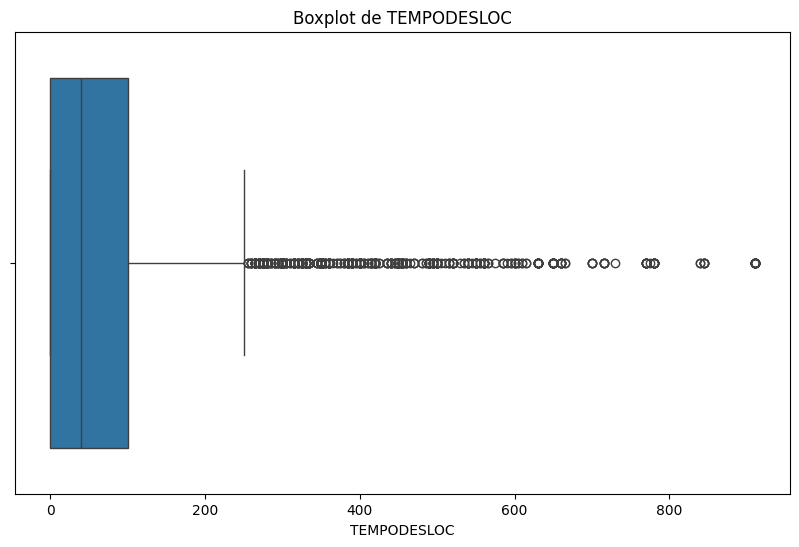

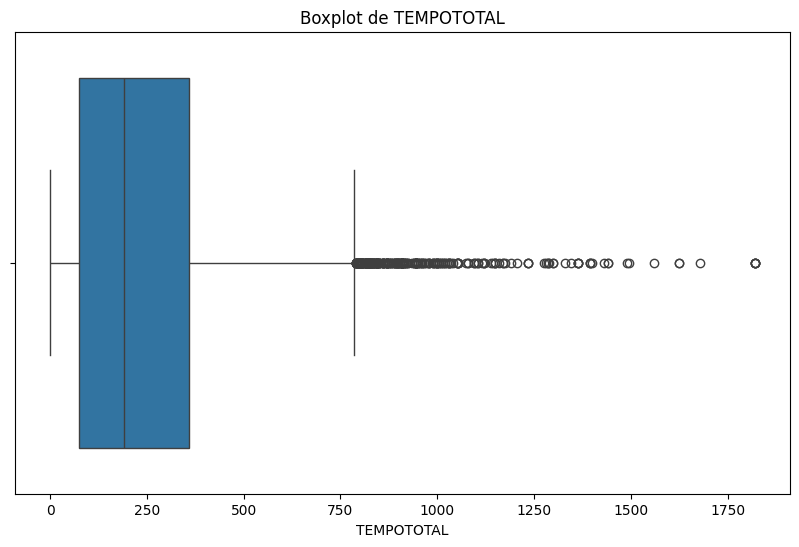

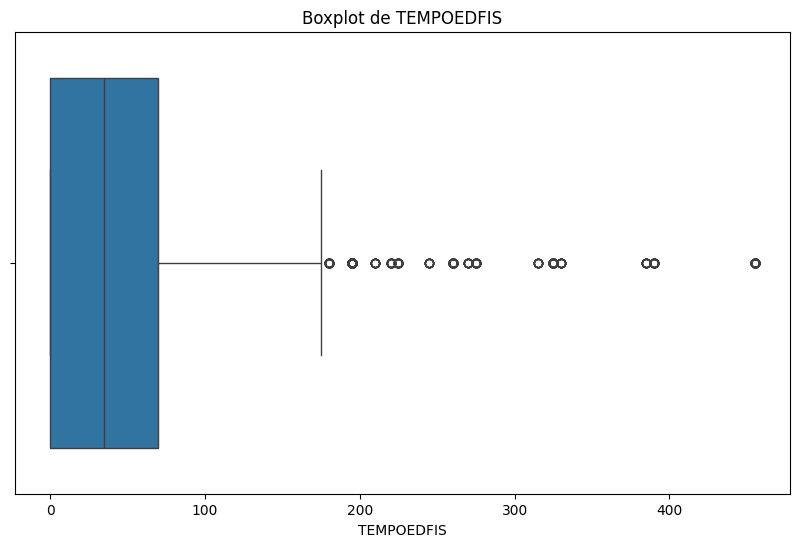

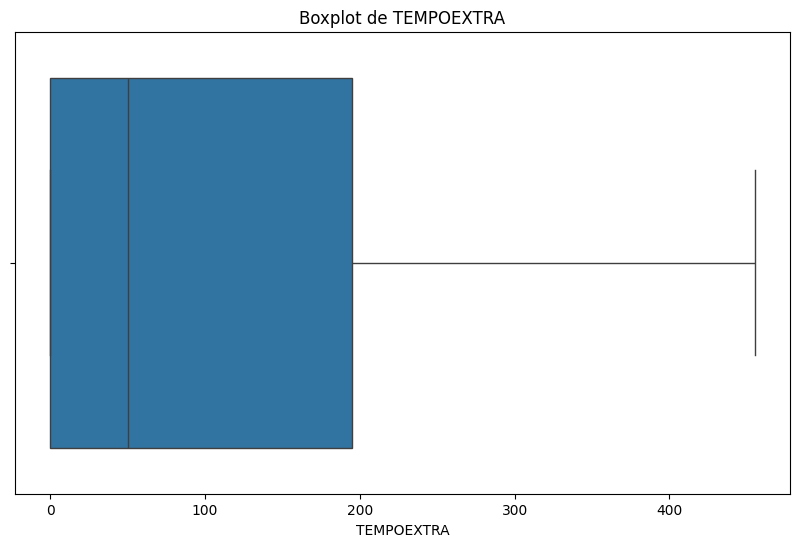

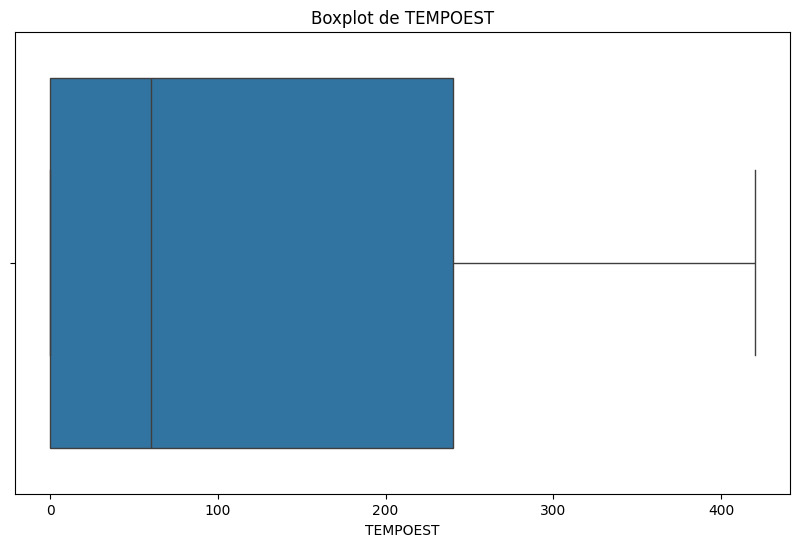

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Múltiplas colunas
features = ['TEMPODESLOC', 'TEMPOTOTAL', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOEST']

# boxplots para cada coluna
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot de {feature}')
    plt.show()

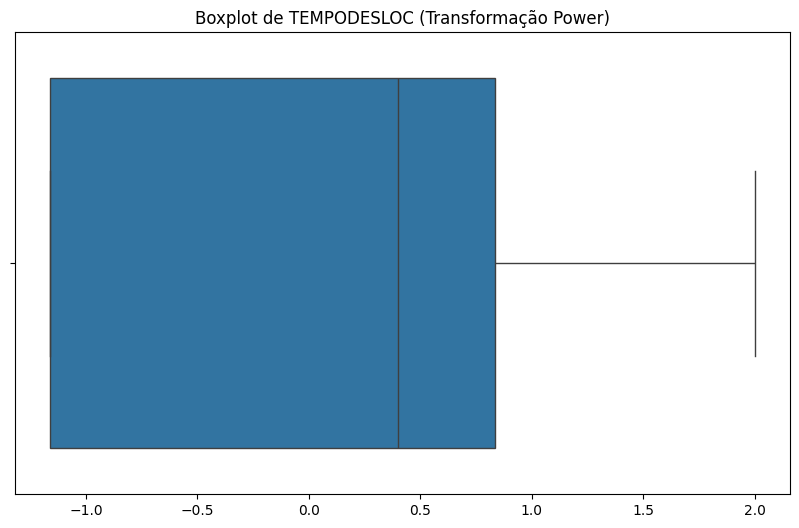

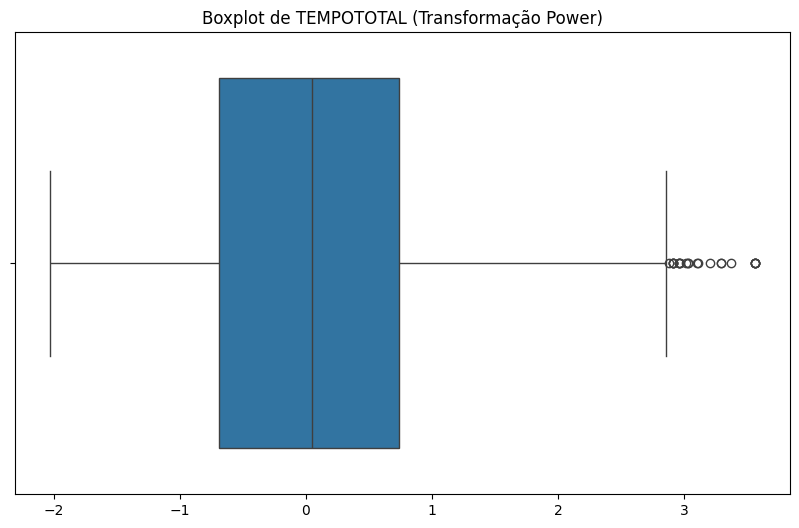

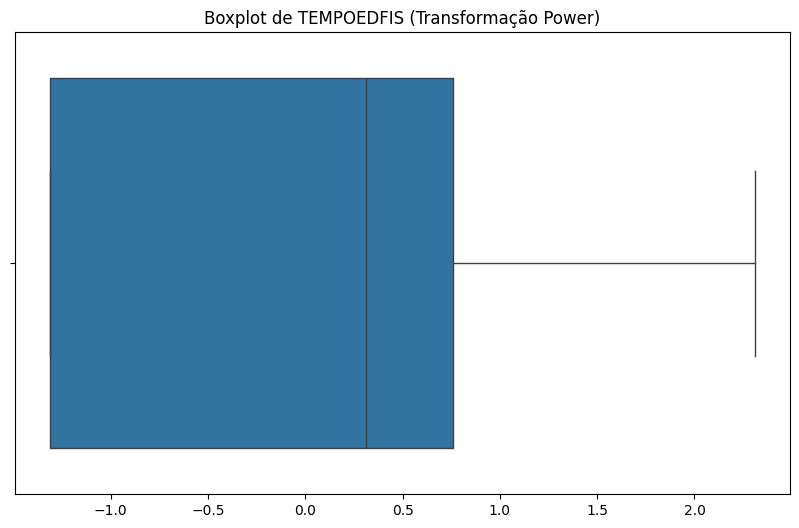

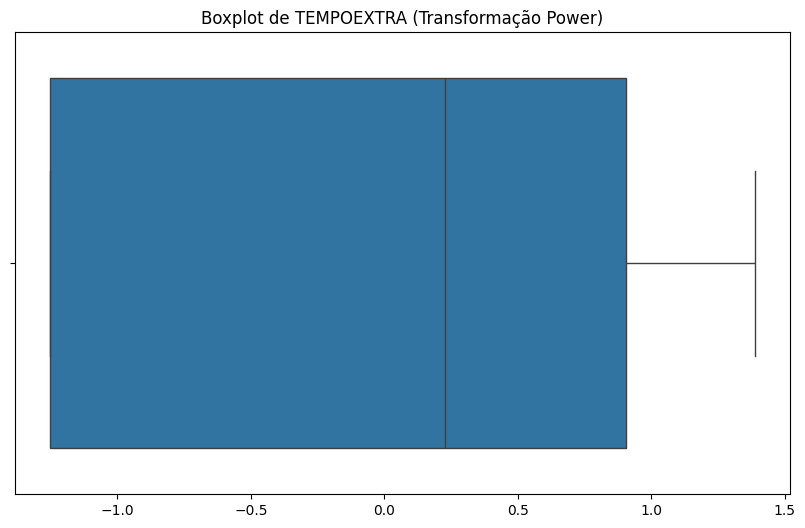

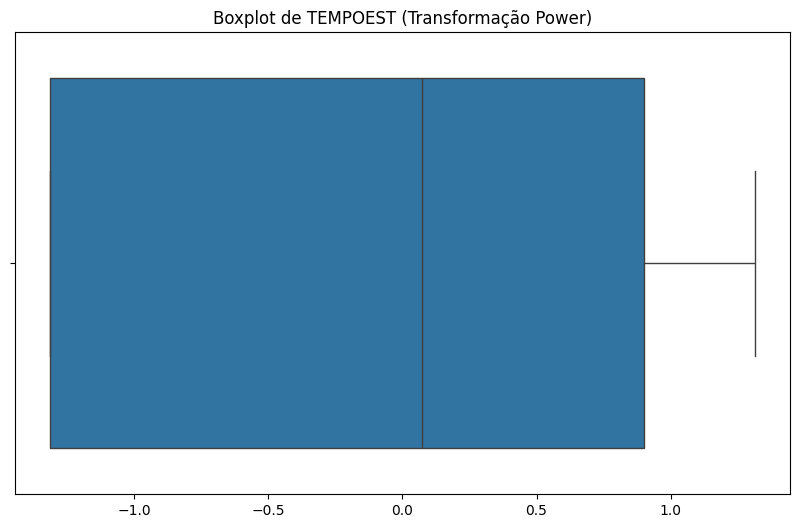

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Aplicando a transformação Power (Box-Cox ou Yeo-Johnson) e criando boxplots para cada coluna
pt = PowerTransformer(method='yeo-johnson')  # 'box-cox' se os dados forem estritamente positivos

for feature in features:
    plt.figure(figsize=(10, 6))

    # A transformação Power é aplicada à coluna
    transformed_data = pt.fit_transform(df[[feature]])

    sns.boxplot(x=transformed_data.flatten())
    plt.title(f'Boxplot de {feature} (Transformação Power)')
    plt.show()

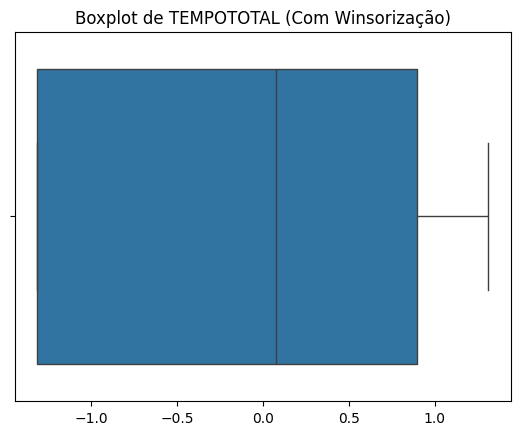

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats # Import the mstats module

# TEMPOTOtAL AINDA TEM OUTLIERS - Aplicar Winsorização, limitando os dados ao 1º e 99º percentil (tentar minimizar)
winsorized_data = mstats.winsorize(transformed_data, limits=[0.01, 0.01])

# Plotar o boxplot dos dados transformados com Winsorização
sns.boxplot(x=winsorized_data.flatten())
plt.title('Boxplot de TEMPOTOTAL (Com Winsorização)')
plt.show()

In [ ]:
# Codificação de variáveis categóricas
# Usar OneHotEncoder para variáveis categóricas
from sklearn.preprocessing import OneHotEncoder # Import OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first')
transformed_df = ohe.fit_transform(df[categorical_cols])
ohe_df = pd.DataFrame(transformed_df, columns=[f"{col}_{cat}" for col, categories in zip(categorical_cols, ohe.categories_) for cat in categories[1:]])
df = pd.concat([df.drop(categorical_cols, axis=1), ohe_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Normalização das variáveis contínuas
from sklearn.preprocessing import StandardScaler # Import the StandardScaler
scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

In [ ]:
# Verificar a presença de valores nulos
null_counts = df.isnull().sum()
print("Valores nulos em cada coluna:")
print(null_counts[null_counts > 0])

Valores nulos em cada coluna:
Series([], dtype: int64)


In [ ]:
df.head()

,TEMPODESLOC,TEMPOTOTAL,TEMPOEDFIS,TEMPOEXTRA,TEMPOEST,trabalha_Sim,cafedamanha_Raramente,"cafedamanha_Sim, 1 a 2 dias por semana","cafedamanha_Sim, 3 a 4 dias por semana","cafedamanha_Sim, 5 a 6 dias por semana",...,imagem_imp_Sem importância,satisf_corp_Insatisfeito,satisf_corp_Muito insatisfeito,satisf_corp_Muito satisfeito,satisf_corp_Satisfeito,imagem_corp_Magro,imagem_corp_Muito gordo,imagem_corp_Muito magro,imagem_corp_Normal,imc_cat_recoded_Sobrepeso e Obesidade
0,-0.662734,-1.077921,-0.798740,-0.702443,-0.523275,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.391249,1.276770,3.402980,0.089315,1.205331,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.662734,1.633541,1.302120,2.326892,2.069635,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.662734,-1.149275,-0.798740,-0.805716,-0.955427,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,-0.399238,-0.364378,0.655701,-0.495898,-0.523275,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Separar as variáveis independentes (X) da variável dependente (y)
X = df.drop('imc_cat_recoded_Sobrepeso e Obesidade', axis=1)
y = df['imc_cat_recoded_Sobrepeso e Obesidade']

In [ ]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

# SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [ ]:
# Verificando o balanceamento
print("Distribuição das classes após SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Distribuição das classes após SMOTE:
imc_cat_recoded_Sobrepeso e Obesidade
1.0    9611
0.0    9611
Name: count, dtype: int64


In [ ]:
# Criar o Pool de dados de treino com as amostras balanceadas
train_pool = Pool(X_train_balanced, y_train_balanced)

In [ ]:
# Instanciar o modelo CatBoost
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, eval_metric='Accuracy', verbose=200)


#treinamento do modelo

In [ ]:
# treinando o modelo com os dados balanceados
model.fit(train_pool)

0:	learn: 0.7705754	total: 302ms	remaining: 5m 1s
200:	learn: 0.8842992	total: 25.6s	remaining: 1m 41s
400:	learn: 0.9208719	total: 40.5s	remaining: 1m
600:	learn: 0.9510977	total: 51.8s	remaining: 34.4s
800:	learn: 0.9727396	total: 1m 3s	remaining: 15.9s
999:	learn: 0.9864218	total: 1m 15s	remaining: 0us


In [ ]:
#importando o grid
from sklearn.model_selection import GridSearchCV

#tunning hiperparametros

In [ ]:
# Definir a grade de hiperparâmetros
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}


In [ ]:
# Fazer a busca em grid
grid_search = GridSearchCV(estimator=CatBoostClassifier(), param_grid=param_grid, scoring='accuracy', cv=3, verbose=3)
grid_search.fit(X_train_balanced, y_train_balanced)

A saída de streaming foi truncada nas últimas 5000 linhas.
1003:	learn: 0.0047516	total: 2m 44s	remaining: 1m 21s
1004:	learn: 0.0047516	total: 2m 44s	remaining: 1m 21s
1005:	learn: 0.0047516	total: 2m 44s	remaining: 1m 20s
1006:	learn: 0.0047515	total: 2m 44s	remaining: 1m 20s
1007:	learn: 0.0047515	total: 2m 44s	remaining: 1m 20s
1008:	learn: 0.0047515	total: 2m 45s	remaining: 1m 20s
1009:	learn: 0.0047515	total: 2m 45s	remaining: 1m 20s
1010:	learn: 0.0047515	total: 2m 45s	remaining: 1m 19s
1011:	learn: 0.0047515	total: 2m 45s	remaining: 1m 19s
1012:	learn: 0.0047515	total: 2m 45s	remaining: 1m 19s
1013:	learn: 0.0047514	total: 2m 45s	remaining: 1m 19s
1014:	learn: 0.0047514	total: 2m 45s	remaining: 1m 19s
1015:	learn: 0.0047514	total: 2m 46s	remaining: 1m 19s
1016:	learn: 0.0047343	total: 2m 46s	remaining: 1m 18s
1017:	learn: 0.0047343	total: 2m 46s	remaining: 1m 18s
1018:	learn: 0.0047343	total: 2m 46s	remaining: 1m 18s
1019:	learn: 0.0047343	total: 2m 46s	remaining: 1m 18s
1020:	

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7c07badbb040>,
             param_grid={'depth': [4, 6, 8], 'iterations': [500, 1000, 1500],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='accuracy', verbose=3)

In [ ]:
# Melhor modelo
best_model = grid_search.best_estimator_

#avaliação do modelo conjunto de treino

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fazer previsões no conjunto de treino balanceado
y_train_pred = best_model.predict(X_train_balanced)

In [ ]:
# Calcular a acurácia no conjunto de treino
train_accuracy = accuracy_score(y_train_balanced, y_train_pred)


In [ ]:
# Relatório de classificação no conjunto de treino
train_report = classification_report(y_train_balanced, y_train_pred)

In [ ]:
# Matriz de confusão no conjunto de treino
train_confusion_matrix = confusion_matrix(y_train_balanced, y_train_pred)
# Exibir os resultados
print(f"Best Parameters: {grid_search.best_params_}") # Changed 'random_search' to 'grid_search'
print(f"Best Cross-Validation Score: {grid_search.best_score_}") # Changed 'random_search' to 'grid_search'
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Classification Report:\n{train_report}")
print(f"Train Confusion Matrix:\n{train_confusion_matrix}")

Best Parameters: {'depth': 8, 'iterations': 1500, 'learning_rate': 0.01}
Best Cross-Validation Score: 0.7929080913178801
Train Accuracy: 0.8962126729788784
Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90      9611
         1.0       0.95      0.84      0.89      9611

    accuracy                           0.90     19222
   macro avg       0.90      0.90      0.90     19222
weighted avg       0.90      0.90      0.90     19222

Train Confusion Matrix:
[[9171  440]
 [1555 8056]]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier

In [ ]:
# Supondo que você já tenha feito a busca de hiperparâmetros e tenha o best_model
# Fazer previsões no conjunto de teste
y_test_pred = best_model.predict(X_test)

In [ ]:
# Calcular a acurácia no conjunto de teste
test_accuracy = accuracy_score(y_test, y_test_pred)


In [ ]:
# Relatório de classificação no conjunto de teste
test_report = classification_report(y_test, y_test_pred)


#AVALIAÇÃO DO MODELO CONJUNTO TESTE

In [ ]:
# Matriz de confusão no conjunto de teste
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Assuming 'grid_search' is the variable holding the results of your hyperparameter search
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Classification Report:\n{test_report}")
print(f"Test Confusion Matrix:\n{test_confusion_matrix}")

Best Parameters: {'depth': 8, 'iterations': 1500, 'learning_rate': 0.01}
Best Cross-Validation Score: 0.7929080913178801
Test Accuracy: 0.8091787439613527
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      2403
         1.0       0.71      0.52      0.60       909

    accuracy                           0.81      3312
   macro avg       0.77      0.72      0.74      3312
weighted avg       0.80      0.81      0.80      3312

Test Confusion Matrix:
[[2208  195]
 [ 437  472]]


In [ ]:
# Avaliar o melhor modelo
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best Accuracy: {accuracy_best}")

Best Accuracy: 0.8091787439613527


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
import shap

# Inicializar o explainer para CatBoost
explainer = shap.TreeExplainer(best_model)

# Calcular os valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(X_test)


In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
# Obter as previsões de probabilidade para a curva ROC
y_pred_prob = best_model.predict_proba(X_test)[:, 1] # Use 'best_model' instead of 'clf'

In [ ]:
# Calcular a AUC-ROC
from sklearn.metrics import roc_curve, auc # Import the auc function
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC:", roc_auc)

In [ ]:
# Import the necessary module
import matplotlib.pyplot as plt

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()